In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


## Data Visualization

In [82]:
nq_1hr = pd.read_csv("archive/NQ_in_1_hour.csv")
nq_1hr.head()

,datetime,symbol,open,high,low,close,volume
0,2024-01-01 23:00:00,CME_MINI:NQ1!,17019.00,17037.00,17013.75,17029.50,4582.0
1,2024-01-02 00:00:00,CME_MINI:NQ1!,17030.00,17030.75,17018.50,17027.00,2270.0
2,2024-01-02 01:00:00,CME_MINI:NQ1!,17026.75,17038.50,17010.75,17014.50,5255.0
3,2024-01-02 02:00:00,CME_MINI:NQ1!,17014.50,17019.00,17001.00,17008.25,3541.0
4,2024-01-02 03:00:00,CME_MINI:NQ1!,17008.25,17013.00,17002.25,17007.50,2024.0


In [83]:
nq_1hr.isna().sum()

datetime    0
symbol      0
open        0
high        0
low         0
close       0
volume      0
dtype: int64

In [84]:
nq_1hr.describe()

,open,high,low,close,volume
count,10504.000000,10504.000000,10504.000000,10504.000000,10504.000000
mean,20389.144707,20418.951066,20357.336205,20389.719393,24376.404703
std,2054.416148,2052.119516,2056.860219,2054.588696,30782.500048
min,16385.750000,16395.000000,16334.250000,16385.500000,276.000000
25%,18651.000000,18676.000000,18624.375000,18651.000000,3894.000000
50%,20217.000000,20241.375000,20186.000000,20217.375000,7802.000000
75%,21726.062500,21752.125000,21685.062500,21726.250000,40075.750000
max,25379.000000,25394.000000,25363.250000,25378.750000,215784.000000


In [85]:
nq_1hr['datetime'] = pd.to_datetime(nq_1hr['datetime'])

## Feature Engineering

In [86]:
nq_1hr["year"] = nq_1hr.datetime.dt.year
nq_1hr["month"] = nq_1hr.datetime.dt.month
nq_1hr["day"] = nq_1hr.datetime.dt.day
nq_1hr["time"] = nq_1hr.datetime.dt.time
nq_1hr['next_close'] = nq_1hr.close.shift(-1)
nq_1hr = nq_1hr.drop(columns=["datetime", "symbol"])
nq_1hr = nq_1hr.dropna()
nq_1hr.head()


,open,high,low,close,volume,year,month,day,time,next_close
0,17019.00,17037.00,17013.75,17029.50,4582.0,2024,1,1,23:00:00,17027.00
1,17030.00,17030.75,17018.50,17027.00,2270.0,2024,1,2,00:00:00,17014.50
2,17026.75,17038.50,17010.75,17014.50,5255.0,2024,1,2,01:00:00,17008.25
3,17014.50,17019.00,17001.00,17008.25,3541.0,2024,1,2,02:00:00,17007.50
4,17008.25,17013.00,17002.25,17007.50,2024.0,2024,1,2,03:00:00,17007.75


In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, r2_score

In [91]:
X = nq_1hr.drop(columns=["next_close", "time"])
y = nq_1hr["next_close"]

In [ ]:
lm = LinearRegression()

Fold 0:
  Train: index=[   0    1    2 ... 1750 1751 1752]
  Test:  index=[1753 1754 1755 ... 3500 3501 3502]
RMSE: 42.66948413543753
R_Squared 0.9980823903233441


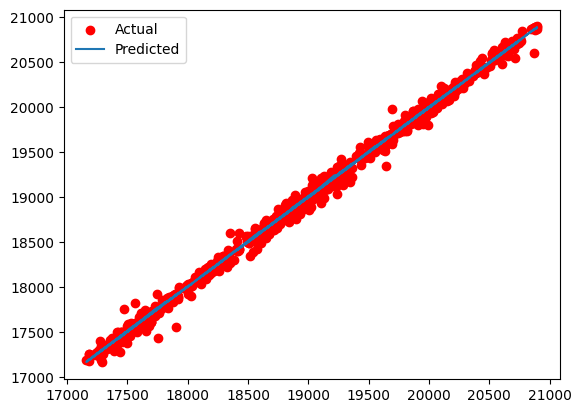

Fold 1:
  Train: index=[   0    1    2 ... 3500 3501 3502]
  Test:  index=[3503 3504 3505 ... 5250 5251 5252]
RMSE: 48.041683866817316
R_Squared 0.9960871015428719


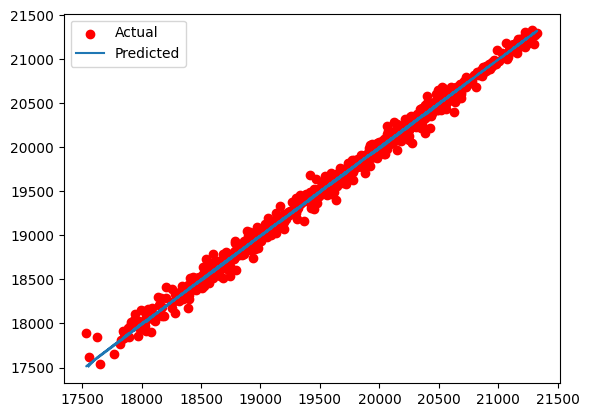

Fold 2:
  Train: index=[   0    1    2 ... 5250 5251 5252]
  Test:  index=[5253 5254 5255 ... 7000 7001 7002]
RMSE: 55.644105085936744
R_Squared 0.9881754657683502


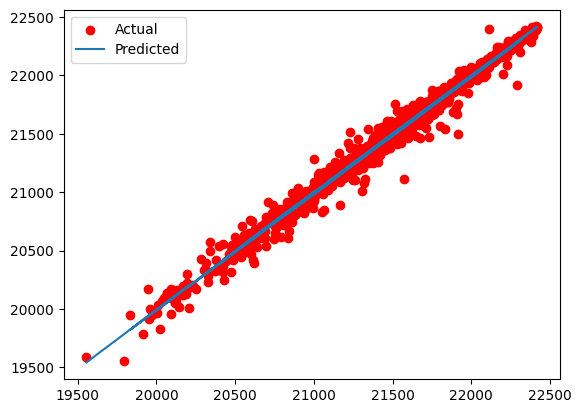

Fold 3:
  Train: index=[   0    1    2 ... 7000 7001 7002]
  Test:  index=[7003 7004 7005 ... 8750 8751 8752]
RMSE: 83.09683462019161
R_Squared 0.996007987725272


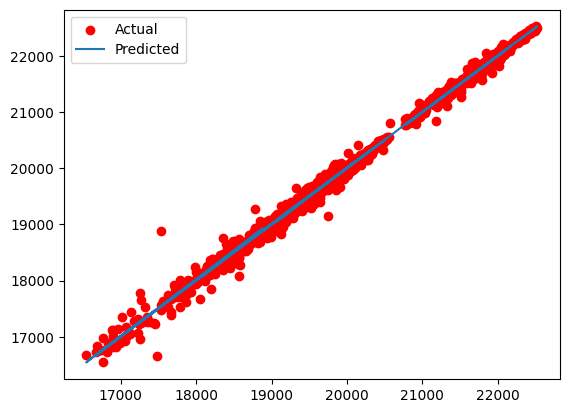

Fold 4:
  Train: index=[   0    1    2 ... 8750 8751 8752]
  Test:  index=[ 8753  8754  8755 ... 10500 10501 10502]
RMSE: 38.53655340371974
R_Squared 0.9972937367941073


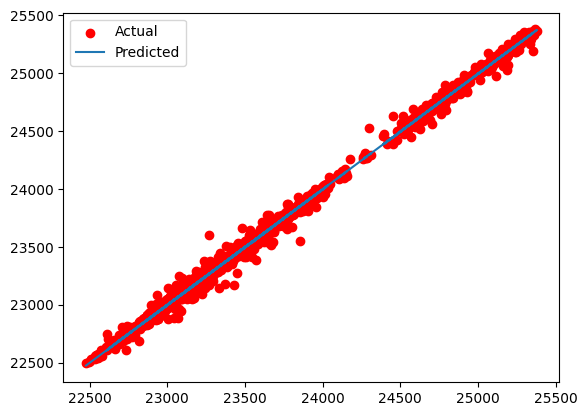

In [116]:
tscv = TimeSeriesSplit()
y_hat = None
for i, (train_index, test_index) in enumerate(tscv.split(nq_1hr)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    lm.fit(X.iloc[train_index], y.iloc[train_index])
    y_hat = lm.predict(X.iloc[test_index])
    rmse = root_mean_squared_error(y.iloc[test_index], y_hat)
    r2 = r2_score(y.iloc[test_index], y_hat)
    print("RMSE:", rmse)
    print("R_Squared", r2)
    plt.scatter(X.close.iloc[test_index], y.iloc[test_index], color = "red", label = "Actual")
    plt.plot(X.close.iloc[test_index], y_hat, label = "Predicted")
    plt.legend()
    plt.show()
    